In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bisect
import statistics

from helper import *

# Project 3

## Keyword Spotting in historical documents with dynamic time warping

### Wicht François-Xavier, Demont Antoine, Mottet Boris, Poplawski Martin, Carrel Vincent

## The DTW measure seems quite unreliable as it is now

Train Validation

In [3]:
h = open("data/task/train.txt", "r")
trainDocs = []
for line in h:
    trainDocs.append(line.strip())
h.close()
print(f"Training docs: {trainDocs}")


h = open("data/task/valid.txt", "r")
valDocs = []
for line in h:
    valDocs.append(line.strip())
h.close()
print(f"Validation docs: {valDocs}")

Training docs: ['270', '271', '272', '273', '274', '275', '276', '277', '278', '279']
Validation docs: ['300', '301', '302', '303', '304']


## Getting words

In [17]:
words = {} 

#ids, frames = Slicer(images=("./data/images", ".jpg"),frames=("./data/ground-truth/locations", ".svg")).get_frames(save=True, savepath="./data/output/")

h = open("data/ground-truth/transcription.txt", "r")
for line in h: 
    for doc in trainDocs: 
        if not line.startswith(doc):
            continue
        image, word = line.split()
        image = np.array(Image.open("data/output/" + doc + "/" + image + ".png"),dtype=float) 
        if not word in words:
            words[word] = []
        words[word] = words[word] + [image]
# print(words)

In [19]:
# Find the threshhold where everything would be classified correctly in the training set. 
# This Threshhold is not well calculated 

# Calculated on the same word and only 5 times..
# Then we take the mean and add half a std to it. 

dtw_values = {}
counter = 0

for images in words: 
    dtw_values[images] = []
    print(counter, '|', end='')
    if counter % 20 == 0:
        print('')
    counter += 1
    occurrences = 0
    for i in range(len(words[images])):
        for j in range(i + 1, len(words[images])):
            if occurrences > 5:
                break
            dtw_values[images] = dtw_values[images] + [(compute_dtw(words[images][i], words[images][j]))]                                    
            occurrences += 1
            

for key in dtw_values:
    values = dtw_values[key]
    if len(values) > 0:
        #TODO Find a better threshhold
        mean = statistics.mean(values)
        dtw_values[key] = mean
        
        #Tried maxValue but it is to lenient
        #maxVal = max(values)
        #dtw_values[key] = maxVal
    else: 
        
        #TODO What to do with words that have only 1 image?
        dtw_values[key] = 150
    
print(dtw_values)
            
#threshhold = np.array(dtw_values).mean() + np.array(dtw_values).std()/2
#print(threshhold)
#print(type(threshhold))

0 |1 |2 |3 |4 |5 |6 |7 |8 |9 |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |24 |25 |26 |27 |28 |29 |30 |31 |32 |33 |34 |35 |36 |37 |38 |39 |40 |41 |42 |43 |44 |45 |46 |47 |48 |49 |50 |51 |52 |53 |54 |55 |56 |57 |58 |59 |60 |61 |62 |63 |64 |65 |66 |67 |68 |69 |70 |71 |72 |73 |74 |75 |76 |77 |78 |79 |80 |81 |82 |83 |84 |85 |86 |87 |88 |89 |90 |91 |92 |93 |94 |95 |96 |97 |98 |99 |100 |101 |102 |103 |104 |105 |106 |107 |108 |109 |110 |111 |112 |113 |114 |115 |116 |117 |118 |119 |120 |121 |122 |123 |124 |125 |126 |127 |128 |129 |130 |131 |132 |133 |134 |135 |136 |137 |138 |139 |140 |141 |142 |143 |144 |145 |146 |147 |148 |149 |150 |151 |152 |153 |154 |155 |156 |157 |158 |159 |160 |161 |162 |163 |164 |165 |166 |167 |168 |169 |170 |171 |172 |173 |174 |175 |176 |177 |178 |179 |180 |181 |182 |183 |184 |185 |186 |187 |188 |189 |190 |191 |192 |193 |194 |195 |196 |197 |198 |199 |200 |201 |202 |203 |204 |205 |206 |207 |208 |209 |210 |211 |212 |213 |214 |215 |216 |217 |218 |219 |220 |221 |

In [20]:
#Check the closest images to the testing image
#Everything is done only on the validation set here

def validate(trained, valid, trainedLabels, validLabels, threshold):
    total = len(valid)
    counter = 0
    stats = {}
    for i in range(len(valid)):
        print(f"{counter}/{total}")
        counter += 1
        results = [] 
        true_positive = 0
        false_positive = 0
        
        results = [(compute_dtw(valid[i], trained[j]), trainedLabels[j]) for j in range(len(trained))]
        results = sorted(results)
        print(validLabels[i])
        if validLabels[i] in threshold.keys():
            index = bisect.bisect([list(k) for k in zip(*results)][0], threshold[validLabels[i]])
        else:
            print("No matches")
            stats[validLabels[i]] = (true_positive,false_positive)
            continue
        print(f"True label is: {validLabels[i]}")
        print(f"Found following matches:")
        for idx in range(index):
            _,noun = results[idx]
            print(results[idx])
            if noun == validLabels[i]:
                true_positive += 1 
            else:
                false_positive += 1 
        stats[validLabels[i]] = (true_positive,false_positive)
    
    return stats
    

In [21]:
valImages = []
valLabels = []
trainImages = []
trainLabels = []

keywords = []
h = open("data/task/keywords.txt", "r")
for line in h:
    keywords.append(line[:-1])


h = open("data/ground-truth/transcription.txt", "r")
for line in h: 
    for doc in valDocs: 
        if not line.startswith(doc):
            continue
        image, word = line.split()
        if word in keywords:
            image = np.array(Image.open("data/output/" + doc + "/" + image + ".png"),dtype=float) 
            valImages.append(image)
            valLabels.append(word)
        
        
h = open("data/ground-truth/transcription.txt", "r")
for line in h: 
    for doc in trainDocs: 
        if not line.startswith(doc):
            continue
        image, word = line.split()
        if word in keywords:
            image = np.array(Image.open("data/output/" + doc + "/" + image + ".png"),dtype=float) 
            trainImages.append(image)
            trainLabels.append(word)

print(f'Training images: {len(trainImages)}\t Validation images: {len(valImages)}\nTraining labels: {len(trainLabels)}\t Validation labels: {len(valLabels)}')

# Takes a lot of time ! (~1 hour)
stats = validate(trainImages, valImages, trainLabels, valLabels, dtw_values)

Training images: 325	 Validation images: 70
Training labels: 325	 Validation labels: 70
0/70
O-r-d-e-r-s
True label is: O-r-d-e-r-s
Found following matches:
(115.57747203714831, 'O-r-d-e-r-s')
(123.35666086793559, 'O-r-d-e-r-s')
(126.66392339948777, 'o-r-d-e-r-e-d')
(128.86946663604655, 'O-r-d-e-r-s')
(133.15294396414419, 'O-r-d-e-r-s')
(148.90533378866158, 'O-r-d-e-r-s')
(153.50260037549918, 'O-r-d-e-r-s')
(154.50846737433758, 'O-r-d-e-r-s')
(155.90150682049585, 'O-r-d-e-r-s')
(160.34222458873205, 'O-r-d-e-r-s')
(165.6513539844034, 'O-r-d-e-r-s')
(166.17939680906903, 'O-r-d-e-r-s')
(169.58306844247144, 't-w-e-l-v-e')
1/70
I-n-s-t-r-u-c-t-i-o-n-s-s_pt
True label is: I-n-s-t-r-u-c-t-i-o-n-s-s_pt
Found following matches:
(162.57572458098008, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt')
(170.74725791317934, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt')
(192.49005226931493, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt')
(193.56328102216182, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt')
(197.61572552662602, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt')
2/70
o

Accuracy: 28.88 %


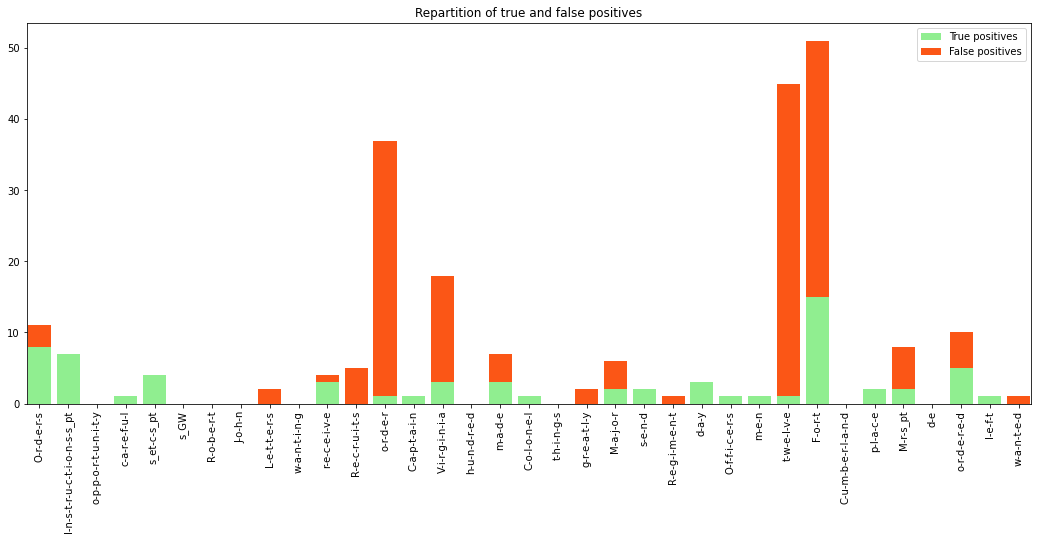

Recall: 40.12 %


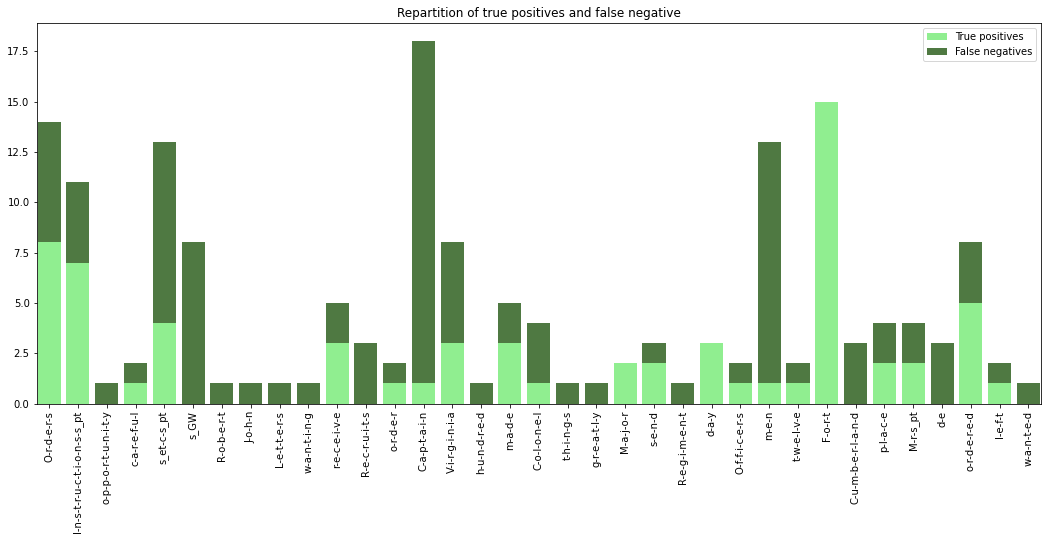

In [24]:
#print(stats)
true_positives = []
false_positives = []
relevent_elements = []
for s in stats:
    tp,fp = stats[s]
    true_positives.append(tp)
    false_positives.append(fp)
    if s in words.keys():
        # Add the number of images contained in the training set that correspond to the word
        relevent_elements.append(len(words[s]))
    else :
        relevent_elements.append(0)
accuracy = sum(true_positives)/(sum(true_positives)+sum(false_positives))
recall = sum(true_positives)/sum(relevent_elements)
false_negatives = [relevent_elements[i] - true_positives[i] for i in range(len(relevent_elements))]
print(f'Accuracy: {round(accuracy*100,2)} %')

plt.figure(figsize=(18,7))
plt.xticks(rotation=90)
plt.bar(stats.keys(), true_positives, label='True positives', color='#90EE90')
plt.bar(stats.keys(), false_positives, bottom=true_positives, label='False positives', color='#FB5616')
plt.margins(x=0.001)
plt.legend()
plt.title('Repartition of true and false positives')
plt.show()

print(f'Recall: {round(recall*100,2)} %')

plt.figure(figsize=(18,7))
plt.xticks(rotation=90)
plt.bar(stats.keys(), true_positives, label='True positives', color='#90EE90')
plt.bar(stats.keys(), false_negatives, bottom=true_positives, label='False negatives', color='#4F7942')
plt.margins(x=0.001)
plt.legend()
plt.title('Repartition of true positives and false negative')
plt.show()

### Observations
For now the results are a bit disappointing, as we have a lot of false positives. We see somewhat of better results for the recall.